In [73]:
import simexpal
import yaml
import numpy as np
import datetime
import matplotlib.pyplot as plt
import functools
import pprint
from scipy.stats import gmean
from num2words import num2words

In [74]:
cfg = simexpal.config_for_dir()

results = []
for run in cfg.collect_successful_results():
    with run.open_output_file() as f:
        yml = yaml.load(f, Loader=yaml.SafeLoader)
    results.append(yml)

for r in results:
    if 'duration_ms' not in r:
        results.remove(r)
    
# pp = pprint.PrettyPrinter(width=41, compact=True)
# pp.pprint(results)

In [75]:
for r in sorted(results, key=lambda r: r['threads']):
    print('Format: {}, {} threads, took {} ms, on graph: {}'.format(
          r['format'], r['threads'], r['duration_ms'], r['graph']))

Format: aspen, 1 threads, took 1647 ms, on graph: cit-Patents
Format: aspen, 1 threads, took 3605171 ms, on graph: com-friendster
Format: aspen, 1 threads, took 123156 ms, on graph: com-orkut
Format: aspen, 1 threads, took 97971 ms, on graph: soc-LiveJournal1
Format: aspen, 1 threads, took 1113738 ms, on graph: soc-twitter-mpi-sws
Format: aspen, 1 threads, took 128289 ms, on graph: tech-p2p
Format: aspen, 1 threads, took 1003178 ms, on graph: web-uk-2005
Format: aspen, 1 threads, took 909795 ms, on graph: web-wikipedia_link_en13
Format: aspen, 1 threads, took 24958 ms, on graph: wiki-topcats
Format: aspen, 1 threads, took 1262 ms, on graph: cit-Patents
Format: aspen, 1 threads, took 118492 ms, on graph: com-friendster
Format: aspen, 1 threads, took 6429 ms, on graph: com-orkut
Format: aspen, 1 threads, took 4344 ms, on graph: soc-LiveJournal1
Format: aspen, 1 threads, took 92556 ms, on graph: soc-twitter-mpi-sws
Format: aspen, 1 threads, took 9037 ms, on graph: tech-p2p
Format: aspen, 

In [76]:
def extractExpThreadTupleIR(ds, exp, insertion_routine, key, sort_by):
    res = []
    for r in sorted(results, key=lambda line: line[sort_by]):
        if r['experiment'] != exp or r['insertion_routine'] != insertion_routine or r['format'] != ds:
            continue
        res.append((r['threads'], r[key]))
    return res

In [77]:
def extractExperimentSingleThread(ds, experiment, algo, key, sort_by):
    res = []
    for r in sorted(results, key=lambda line: line[sort_by]):
        if r['format'] != ds  or r['threads'] != 1 or r['experiment'] != experiment or r['algo'] != algo:
            continue
        res.append(r[key])
    return res

In [78]:
def expXThreadIR(ds, experiment, insertion_routine, key, t, sort_by):
    res = []
    for r in sorted(results, key=lambda line: line[sort_by]):
        if r['format'] != ds or r['threads'] != t or r['experiment'] != experiment or r['insertion_routine'] != insertion_routine :
            continue
        res.append(r[key])
    return res

In [79]:
dhb_color = 'tomato'
nk_color = 'royalblue'
stinger_color = 'gold'
csr_color = 'grey'
aspen_color = 'orchid'
terrace_color = 'yellowgreen'

In [80]:
nk_ds = 'NetworKit'
dhb_ds = 'DHB'
stinger_ds = 'Stinger'
csr_ds = 'CSR'
aspen_ds = 'aspen'
terrace_ds = 'terrace'

In [81]:
# dhb_hatch = "\\\\\\"
# nk_hatch = "///"
# stinger_hatch = '...'
# csr_hatch = 'xxx'
# aspen_hatch = '---'
# terrace_hatch = '+++'

dhb_hatch = ""
nk_hatch = ""
stinger_hatch = ''
csr_hatch = ''
aspen_hatch = ''
terrace_hatch = ''

In [82]:
def gds_name_remap(origin_name):
    d = {
        nk_ds: 'NetworKit',
        dhb_ds: 'DHB',
        stinger_ds: 'STINGER',
        csr_ds: 'CSR',
        aspen_ds: 'Aspen',
        terrace_ds: 'Terrace',
    }
    
    if origin_name in d:
        return d[origin_name]
    else:
        return 'Unknown!'

In [83]:
def abbreviate_name(graph_name):
    d = {
        'soc-flickr-growth': 'flickr',
        'rec-epinions-user-ratings': 'epns-user',
        'rec-amazon-ratings': 'amzn-rat',
        'a-stackexch-user-marks-post-und': 'stackexch',
        'soc-epinions-trust-dir': 'epns-trust',
        'soc-youtube-growth': 'youtube',
        'sx-stackoverflow': 'stackoverflow',
        'wiki-Talk': 'wiki',
        'cit-Patents': 'patents',
        'roadNet-CA': 'roadNet',
        'amazon0601': 'amzn0601',
        'web-Google': 'Google',
        'web-BerkStan': 'BerkStan',
        'wiki-topcats': 'topcats',
        'soc-LiveJournal1': 'LiveJournal',
        'wiki-talk-temporal': 'wiki-temp',
        'ia-stackexch-user-marks-post-und': 'stackexch',
        'com-friendster': 'friendster',
        'dimacs10-uk-2007-05': 'uk2007',
        'web-ClueWeb09.edges': 'ClueWeb09',
        'soc-twitter-mpi-sws': 'twitter-mpi',
        'com-orkut': 'orkut',
        'tech-p2p': 'tech-p2p',
        'web-uk-2005': 'web-uk2005',
        'web-wikipedia_link_en13': 'wiki-link',
    }
    
    if graph_name in d:
        return d[graph_name]
    else:
        return 'Unknown!'

In [84]:
def graph_abbreviation():
    abbreviations = dict()
    sort_by = 'edges_read_in'
    for r in sorted(results, key=lambda r: sort_by):
        graph_name = r['graph']
        if graph_name not in abbreviations and len(graph_name) > 0:
            abbreviations[graph_name] = ''
            
    for name in abbreviations.items():
        abbr = abbreviate_name(name[0])
        if abbr in abbreviations.values():
            abbr += '1'
        abbreviations[name[0]] = abbr
        
    return abbreviations

In [85]:
# return min, max, average degree of the graph
def graph_degree_distribution(graph_name):
    d = {
        'web-uk-2005': (1, 1776852, 23.7),
        'web-BerkStan': (0, 249, 11.1),
        'sx-stackoverflow': (0, 42197, 10.9),
        'cit-Patents': (0, 770, 2.8),
        'wiki-topcats': (0, 3907, 16.0),
        'soc-LiveJournal1': (0, 20293, 14.3),
        'com-orkut': (0, 33007, 38.2),
        'soc-epinions-trust-dir': (0, 2070, 6.4),
        'ia-stackexch-user-marks-post-und': (0, 4917, 2.4),
        'wiki-talk-temporal': (0, 141884, 3.0),
        'soc-youtube-growth': (0, 83292, 3.0),
        'rec-epinions-user-ratings': (0, 162169, 18.1),
        'soc-flickr-growth': (0, 26367, 14.4),
        'web-wikipedia_link_en13': (0, 37044, 20.2),
        'com-friendster': (0, 3615, 14.5),
        'soc-twitter-mpi-sws': (0, 2997469, 35.3),
        'tech-p2p': (1, 10671, 25.6),
        
        # 'rec-amazon-ratings': 'amzn-rat',
        # 'a-stackexch-user-marks-post-und': 'stackexch',
        # 'roadNet-CA': 'roadNet',
        # 'amazon0601': 'amzn0601',
        # 'wiki-Talk': 'wiki',
        # 'web-Google': 'Google',
        # 'dimacs10-uk-2007-05': 'uk2007',
        # 'web-ClueWeb09.edges': 'ClueWeb09',
    }
    
    if graph_name in d:
        return d[graph_name]
    else:
        return (0, 0, 0.0)

In [86]:
def static_graph_summary():
    g_abbr = graph_abbreviation()
    
    graphs = list()
    sort_by = 'edges_read_in'
    used_graphs = list()
    for r in sorted(results, key=lambda r: r[sort_by]):
        graph_name = r['graph']
        if graph_name not in used_graphs and len(graph_name) > 0 and r['experiment'] == 'dhb_insert_static':
            deg_dist = graph_degree_distribution(graph_name)
            graphs.append((graph_name, g_abbr[graph_name], deg_dist[0], deg_dist[1], deg_dist[2], r['vertex_count'], r['edges_read_in']))
            used_graphs.append(graph_name)
    
    graphs.sort(key=lambda y: y[6])
            
    return graphs

In [87]:
def dynamic_graph_summary():
    g_abbr = graph_abbreviation()
    
    graphs = list()
    sort_by = 'edges_read_in'
    used_graphs = list()
    for r in sorted(results, key=lambda r: r[sort_by]):
        graph_name = r['graph']
        
        if graph_name not in used_graphs and len(graph_name) > 0 and r['experiment'] == 'dhb_temporal_insertions':
            deg_dist = graph_degree_distribution(graph_name)
            graphs.append((graph_name, g_abbr[graph_name], deg_dist[0], deg_dist[1], deg_dist[2], r['vertex_count'], r['edges_read_in'], r['edge_count_after']))
            used_graphs.append(graph_name)
            
    graphs.sort(key=lambda y: y[6])
    
    return graphs

In [88]:
def write_dynamic_graph_summary_to_file():
    with open('plots/dynamic_graph_summary.tex', 'w') as graph_summary_file:
        graphs = dynamic_graph_summary()
        print('% Graph Name, Graph Abbreviation, $\deg_{\min}$, $\deg_{\max}$, $\deg_{mean}$, Highest Vertex ID, Edges Read In, Edge Count After Insert/Update',
              file=graph_summary_file)
        for g in graphs:
            print(g[0] + ' & ' + g[1] + ' & ' + str(g[2]) + ' & ' + str(g[3]) + ' & ' + str(g[4]) + ' & ' + str(g[5]) + ' & ' + str(g[6]) + ' & ' + str(g[7]) + '\\\\', file=graph_summary_file)

In [89]:
def write_static_graph_summary_to_file():
    with open('plots/static_graph_summary.tex', 'w') as graph_summary_file:
        graphs = static_graph_summary()
        print('% Graph Name, Graph Abbreviation, , $\deg_{\min}$, $\deg_{\max}$, $\deg_{mean}$, Highest Vertex ID, Edges Read In',
              file=graph_summary_file)
        for g in graphs:
            print(g[0] + ' & ' + g[1] + ' & ' + str(g[2]) + ' & ' + str(g[3]) + ' & ' + str(g[4]) + ' & ' + str(g[5]) + ' & ' + str(g[6]) + '\\\\', file=graph_summary_file)

In [90]:
def get_abbr_for_graphs(graphs):
    abbreviations = graph_abbreviation()
    replacements = []
    
    for g in graphs:
        replacements.append(abbreviations[g])
    
    return replacements

In [91]:
def factor_compared_to(team, opponent):
    factors = []
    for t, o in zip(team, opponent):
        factors.append(o / t)
    
    gemetric_mean = gmean(factors)
    
    return gemetric_mean

In [92]:
def append_to_factor_file(name, factor):
    rounded_factor = round(factor,1)
    with open('plots/comparing_factors.tex', 'a') as factor_file:
        print('\\newcommand{\\' + name + '}{' + str(rounded_factor) + '}', file=factor_file)

In [93]:
# Set on True if you want to save all the plots
save_all_plots=True

In [94]:
write_static_graph_summary_to_file()
write_dynamic_graph_summary_to_file()

In [95]:
timeout = 1800000. # 1800 seconds

def ceil_timeout(times):
    return [min(timeout, t) for t in times]

In [96]:
def temporal_insertion(thread_count, save=False):
    insertion_routine = 'temporal_insertions'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_temporal_insertions', insertion_routine, 'graph', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, 'dhb_temporal_insertions', insertion_routine, 'edges_read_in', thread_count, sort_by)
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_temporal_insertions', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    nk_times = expXThreadIR(nk_ds, 'networkit_temporal_insertions', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    aspen_times = expXThreadIR(aspen_ds, 'aspen_temporal_insertions', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = ceil_timeout(aspen_times)
    print('aspen_times: ' + str(aspen_times))
    stinger_times = expXThreadIR(stinger_ds,  'stinger_temporal_insertions', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    print('stinger_times: ' + str(stinger_times))
    terrace_times = expXThreadIR(terrace_ds,  'terrace_temporal_insertions', insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = ceil_timeout(terrace_times)
    print('terrace_times: ' + str(terrace_times))
    
    fig, ax = plt.subplots()
    ax.set_ylabel('nanoseconds per edge insertion')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    nk_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(nk_times, edges)]
    dhb_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_times, edges)]
    stinger_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(stinger_times, edges)]
    aspen_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(aspen_times, edges)]
    terrace_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(terrace_times, edges)]
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.15 
    
    ax.bar(x - 2*width, nk_times_per_edge, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - 1*width, stinger_times_per_edge, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x + 0*width, aspen_times_per_edge, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + 1*width, terrace_times_per_edge, 
           width, label=gds_name_remap(terrace_ds), color=terrace_color, hatch=terrace_hatch, edgecolor='black')
    ax.bar(x + 2*width, dhb_times_per_edge, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
       plt.savefig('plots/nk_v_stinger_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                             factor_compared_to(dhb_times_per_edge, nk_times_per_edge))
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                              factor_compared_to(dhb_times_per_edge, stinger_times_per_edge))
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                              factor_compared_to(dhb_times_per_edge, aspen_times_per_edge)) 
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
                              factor_compared_to(dhb_times_per_edge, terrace_times_per_edge))
    else:
        plt.show()

edges: [841371, 1302438, 7833139, 12223773, 13668319, 33140016, 47903265]
nk_times: [116, 324, 8422, 8137, 36249, 11282, 40268]
aspen_times: [1861, 3054, 22307, 33276, 50536, 104822, 178401]
stinger_times: [517, 994, 137216, 61395, 1308490, 69008, 479076]
terrace_times: [572, 2747, 6218, 20305, 4265, 14558, 16957]


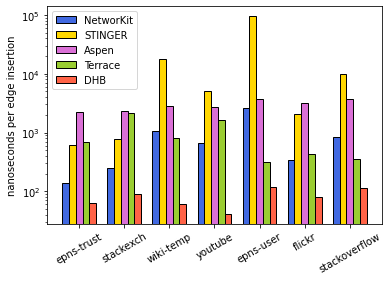

In [97]:
temporal_insertion(1, save=save_all_plots)

In [98]:
def temporal_updates(thread_count, save=False):
    insertion_routine = 'temporal_updates'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_temporal_updates', insertion_routine, 'graph', thread_count, sort_by)
    edges = [e * 0.5 for e in expXThreadIR(dhb_ds, 'dhb_temporal_updates', insertion_routine, 'edges_read_in', thread_count, sort_by)]
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_temporal_updates', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    nk_times = expXThreadIR(nk_ds, 'networkit_temporal_updates', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    stinger_times = expXThreadIR(stinger_ds,  'stinger_temporal_updates', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    print('stinger_times: ' + str(stinger_times))
    
    stinger_times.insert(4, 1800000.)
    
    fig, ax = plt.subplots()
    ax.set_ylabel('nanoseconds per edge update')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    nk_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(nk_times, edges)]
    dhb_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_times, edges)]
    stinger_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(stinger_times, edges)]
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.15 
    
    ax.bar(x - width, nk_times_per_edge, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x, stinger_times_per_edge, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x + width, dhb_times_per_edge, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
        plt.savefig('plots/nk_v_stinger__v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                              factor_compared_to(dhb_times_per_edge, nk_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                              factor_compared_to(dhb_times_per_edge, stinger_times_per_edge))
    else:
        plt.show()

edges: [420685.5, 651219.0, 3916569.5, 6111886.5, 6834159.5, 16570008.0, 23951632.5]
nk_times: [146, 311, 17141, 11548, 35241, 32733, 76008]
stinger_times: [395, 352, 62437, 104349, 131197, 389540]


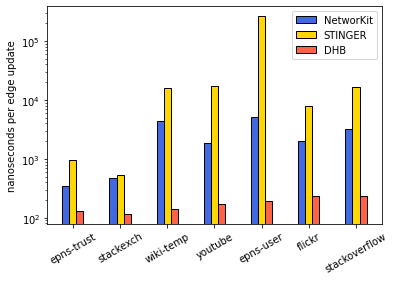

In [99]:
temporal_updates(1, save=save_all_plots)

In [100]:
def temporal_deletions(thread_count, save=False):
    insertion_routine = 'temporal_deletions'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_temporal_deletions', insertion_routine, 'graph', thread_count, sort_by)
    edges = [e * 0.5 for e in expXThreadIR(dhb_ds, 'dhb_temporal_deletions', insertion_routine, 'edges_read_in', thread_count, sort_by)]
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_temporal_deletions', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    nk_times = expXThreadIR(nk_ds, 'networkit_temporal_deletions', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    aspen_times = expXThreadIR(aspen_ds, 'aspen_temporal_deletions', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = ceil_timeout(aspen_times)
    print('aspen_times: ' + str(aspen_times))
    terrace_times = expXThreadIR(terrace_ds, 'terrace_temporal_deletions', insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = ceil_timeout(terrace_times)
    print('terrace_times: ' + str(terrace_times))
    
    fig, ax = plt.subplots()
    ax.set_ylabel('nanoseconds per edge deletion')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    nk_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(nk_times, edges)]
    dhb_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_times, edges)]
    aspen_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(aspen_times, edges)]
    terrace_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(terrace_times, edges)]
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.15 
    
    ax.bar(x - 1.5*width, nk_times_per_edge, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - 0.5*width, aspen_times_per_edge, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + 0.5*width, terrace_times_per_edge, 
           width, label=gds_name_remap(terrace_ds), color=terrace_color, hatch=terrace_hatch, edgecolor='black')
    ax.bar(x + 1.5*width, dhb_times_per_edge, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
       plt.savefig('plots/nk_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                              factor_compared_to(dhb_times_per_edge, nk_times_per_edge))
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                              factor_compared_to(dhb_times_per_edge, aspen_times_per_edge))
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
                              factor_compared_to(dhb_times_per_edge, terrace_times_per_edge))
    else:
        plt.show()

edges: [420685.5, 651219.0, 3916569.5, 6111886.5, 6834159.5, 16570008.0, 23951632.5]
nk_times: [128, 233, 11475, 8293, 22912, 25630, 53503]
aspen_times: [1739, 2806, 24142, 27461, 45926, 103203, 183146]
terrace_times: [566, 2723, 6161, 20213, 4115, 14491, 16810]


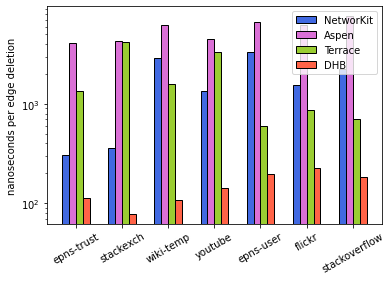

In [101]:
temporal_deletions(1, save=save_all_plots)

In [104]:
def bfs(thread_count, save=False):
    insertion_routine = 'bfs'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_bfs', insertion_routine, 'graph', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, 'dhb_bfs', insertion_routine, 'edges_read_in', thread_count, sort_by)
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_bfs', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    
    aspen_times = expXThreadIR(aspen_ds, 'aspen_bfs', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times.insert(0, dhb_times[0])
    aspen_times = ceil_timeout(aspen_times)
    print('aspen_times: ' + str(aspen_times))
    
    stinger_times = expXThreadIR(stinger_ds, 'stinger_bfs', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    print('stinger_times: ' + str(stinger_times))
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)

    nk_times = expXThreadIR(nk_ds, 'networkit_bfs', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    nk_times.insert(6, 1800000.)
    nk_times.insert(8, 1800000.)

    terrace_times = expXThreadIR(terrace_ds, 'terrace_bfs', insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = ceil_timeout(terrace_times)
    print('terrace_times: ' + str(terrace_times))
    terrace_times.append(1800000.)
    terrace_times.append(1800000.)
    terrace_times.append(1800000.)
    terrace_times.append(1800000.)
    
    fig, ax = plt.subplots()
    ax.set_ylabel('ms')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.15 
    
    ax.bar(x - 2*width, nk_times, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - 1*width, stinger_times, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x + 0*width, aspen_times, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + 1*width, terrace_times, width, label=gds_name_remap(terrace_ds), 
           color=terrace_color, hatch=terrace_hatch, edgecolor='black', align='center')
    ax.bar(x + 2*width, dhb_times, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    # timeout limit
    plt.axhline(y=1800000., color='black', linestyle='--', alpha=0.5, label='Timeout')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend(loc='lower right')

    if save:
        plt.savefig('plots/nk_v_stinger_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                              factor_compared_to(dhb_times, aspen_times))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                              factor_compared_to(dhb_times, stinger_times))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                              factor_compared_to(dhb_times, nk_times))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
                              factor_compared_to(dhb_times, terrace_times))
    else:
        plt.show()

edges: [7600594, 16518947, 28511806, 68993772, 117185082, 147830697, 601038300, 936364281, 1468365181, 1806067134]
aspen_times: [1839, 1647, 24958, 97971, 123156, 128289, 909795, 1003178, 1113738, 1800000.0]
stinger_times: [5178, 2500, 49502, 86580, 46845, 172137, 308942, 947792]
nk_times: [2350, 3214, 27409, 51912, 28790, 40483, 475075, 299774]
terrace_times: [24008, 71754, 101312, 127425, 150779, 102396]


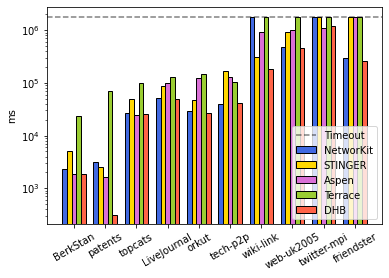

In [105]:
bfs(1, save=save_all_plots)

In [108]:
def spgemm(thread_count, save=False):
    insertion_routine = 'spgemm'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_spgemm', insertion_routine, 'graph', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, 'dhb_spgemm', insertion_routine, 'edges_read_in', thread_count, sort_by)
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_spgemm', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    aspen_times = expXThreadIR(aspen_ds, 'aspen_spgemm', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = ceil_timeout(aspen_times)
    print('aspen_times: ' + str(aspen_times))
    stinger_times = expXThreadIR(stinger_ds, 'stinger_spgemm', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    print('stinger_times: ' + str(stinger_times))
    stinger_times.insert(0, 1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    stinger_times.append(1800000.)
    
    nk_times = expXThreadIR(nk_ds, 'networkit_spgemm', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    nk_times.append(1800000.)
    nk_times.append(1800000.)
    nk_times.append(1800000.)
    nk_times.append(1800000.)
    nk_times.append(1800000.)
    nk_times.append(1800000.)
    nk_times.append(1800000.)
    nk_times.append(1800000.)

    terrace_times = expXThreadIR(terrace_ds, 'terrace_spgemm', insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = ceil_timeout(terrace_times)
    print('terrace_times: ' + str(terrace_times))
    
    fig, ax = plt.subplots()
    ax.set_ylabel('ms')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.15
    
    ax.bar(x - 2*width, nk_times, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - 1*width, stinger_times, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x + 0*width, aspen_times, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + 1*width, terrace_times, width, label=gds_name_remap(terrace_ds), 
           color=terrace_color, hatch=terrace_hatch, edgecolor='black', align='center')
    ax.bar(x + 2*width, dhb_times, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)

    # timeout limit
    plt.axhline(y=1800000., color='black', linestyle='--', alpha=0.5, label='Timeout')
    
    ax.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    if save:
       plt.savefig('plots/nk_v_stinger_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
              bbox_inches='tight')
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                            factor_compared_to(dhb_times, aspen_times))
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                            factor_compared_to(dhb_times, stinger_times))
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                              factor_compared_to(dhb_times,nk_times))        
       append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
                              factor_compared_to(dhb_times,terrace_times))
    else:
        plt.show()

edges: [7600594, 16518947, 28511806, 68993772, 117185082, 147830697, 601038300, 936364281, 1468365181, 1806067134]
aspen_times: [5247, 9706, 6222, 7609, 7679, 9577, 8833, 7054, 11750, 8933]
stinger_times: [35746]
nk_times: [290571, 23364]
terrace_times: [5465, 43505, 12242, 33417, 21041, 40594, 223960, 333683, 362366, 1136523]


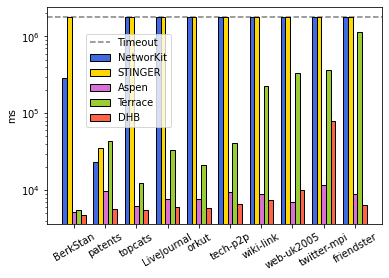

In [109]:
spgemm(1, save=save_all_plots)

In [110]:
def insert_bulk(thread_count, save=False):
    insertion_routine = 'insert_bulk'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_insert_bulk_static', insertion_routine, 'graph', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, 'dhb_insert_bulk_static', insertion_routine, 'edges_read_in', thread_count, sort_by)
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_insert_bulk_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    nk_times = expXThreadIR(nk_ds, 'networkit_insert_bulk_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    aspen_times = expXThreadIR(aspen_ds, 'aspen_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = ceil_timeout(aspen_times)
    print('aspen_times: ' + str(aspen_times))
    stinger_times = expXThreadIR(stinger_ds,  'stinger_insert_bulk_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    stinger_times.insert(8, 1800000.) # timeout on soc-twitter
    print('stinger_times: ' + str(stinger_times))
    terrace_times = expXThreadIR(terrace_ds,  'terrace_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = ceil_timeout(terrace_times)
    terrace_times.append(1800000.) # timeout on soc-twitter
    terrace_times.append(1800000.) # timeout on friendster
    print('terrace_times: ' + str(terrace_times))
    
    fig, ax = plt.subplots()
    ax.set_ylabel('nanoseconds per edge insertion')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    nk_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(nk_times, edges)]
    dhb_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_times, edges)]
    stinger_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(stinger_times, edges)]
    aspen_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(aspen_times, edges)]
    terrace_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(terrace_times, edges)]
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.17
    
    ax.bar(x - 2*width, nk_times_per_edge, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - 1*width, stinger_times_per_edge, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x + 0*width, aspen_times_per_edge, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + 1*width, terrace_times_per_edge, width, label=gds_name_remap(terrace_ds), 
           color=terrace_color, hatch=terrace_hatch, edgecolor='black', align='center')
    ax.bar(x + 2*width, dhb_times_per_edge, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
        plt.savefig('plots/nk_v_stinger_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                              factor_compared_to(dhb_times_per_edge, nk_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                              factor_compared_to(dhb_times_per_edge, stinger_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                              factor_compared_to(dhb_times_per_edge, aspen_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
                              factor_compared_to(dhb_times_per_edge, terrace_times_per_edge))
    else:
        plt.show()

edges: [7600594, 16518947, 28511806, 68993772, 117185082, 147830697, 601038300, 936364281, 1468365181, 1806067134]
nk_times: [530, 5010, 3638, 12744, 21699, 26258, 95551, 61856, 386002, 710277]
aspen_times: [461, 1262, 1855, 4344, 6429, 9037, 38790, 55244, 92556, 118492]
stinger_times: [2092, 4173, 9558, 27144, 127522, 268991, 381700, 388684, 1800000.0, 1348131]
terrace_times: [12329, 60424, 42461, 109569, 156924, 215380, 905798, 1420611, 1800000.0, 1800000.0]


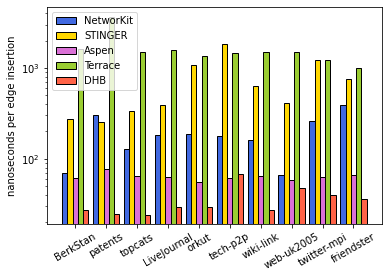

In [111]:
insert_bulk(1, save=save_all_plots)

In [113]:
def insert(thread_count, save=False):
    insertion_routine = 'insert'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_insert_static', insertion_routine, 'graph', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, 'dhb_insert_static', insertion_routine, 'edges_read_in', thread_count, sort_by)
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    nk_times = expXThreadIR(nk_ds, 'networkit_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    nk_times = ceil_timeout(nk_times)
    print('nk_times: ' + str(nk_times))
    aspen_times = expXThreadIR(aspen_ds, 'aspen_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = ceil_timeout(aspen_times)
    aspen_times.insert(9, 1800000.) # friendster
    print('aspen_times: ' + str(aspen_times))
    stinger_times = expXThreadIR(stinger_ds,  'stinger_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    stinger_times.insert(4, 1800000.) # orkut
    stinger_times.insert(5, 1800000.) # tech-p2p
    stinger_times.insert(6, 1800000.) # wiki-link
    stinger_times.insert(7, 1800000.) # web-uk-2005
    stinger_times.insert(8, 1800000.) # twitter mpi
    stinger_times.insert(9, 1800000.) # friendster
    print('stinger_times: ' + str(stinger_times))
    terrace_times = expXThreadIR(terrace_ds, 'terrace_insert_static', insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = ceil_timeout(terrace_times)
    print('terrace_times: ' + str(terrace_times))
    
    
    print('stinger_times: ' + str(stinger_times))
    
    fig, ax = plt.subplots()
    ax.set_ylabel('nanoseconds per edge insertion')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    nk_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(nk_times, edges)]
    dhb_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_times, edges)]
    stinger_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(stinger_times, edges)]
    aspen_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(aspen_times, edges)]
    terrace_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(terrace_times, edges)]
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.17
    
    ax.bar(x - 2*width, nk_times_per_edge, 
           width, label=gds_name_remap(nk_ds), color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - 1*width, stinger_times_per_edge, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x + 0*width, aspen_times_per_edge, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + 1*width, terrace_times_per_edge, width, label=gds_name_remap(terrace_ds), 
           color=terrace_color, hatch=terrace_hatch, edgecolor='black', align='center')
    ax.bar(x + 2*width, dhb_times_per_edge, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
        plt.savefig('plots/nk_v_stinger_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + nk_ds,
                              factor_compared_to(dhb_times_per_edge, nk_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                              factor_compared_to(dhb_times_per_edge, stinger_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                              factor_compared_to(dhb_times_per_edge, aspen_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
                              factor_compared_to(dhb_times_per_edge, terrace_times_per_edge))
    else:
        plt.show()

edges: [7600594, 16518947, 28511806, 68993772, 117185082, 147830697, 601038300, 936364281, 1468365181, 1806067134]
nk_times: [526, 4941, 3639, 12415, 21586, 26184, 94767, 61959, 338813, 903990]
aspen_times: [17835, 43762, 76514, 191720, 335714, 517646, 1800000.0, 1800000.0, 1800000.0, 1800000.0]
stinger_times: [192995, 17538, 1130737, 124425, 1800000.0, 1800000.0, 1800000.0, 1800000.0, 1800000.0, 1800000.0]
terrace_times: [3633, 39367, 10611, 32153, 21031, 43869, 226642, 356574, 377938, 1170913]
stinger_times: [192995, 17538, 1130737, 124425, 1800000.0, 1800000.0, 1800000.0, 1800000.0, 1800000.0, 1800000.0]


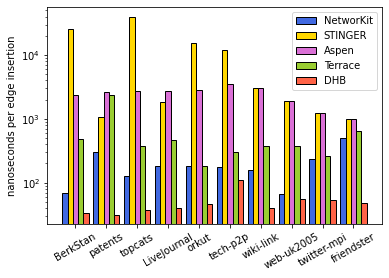

In [114]:
insert(1, save=save_all_plots)

In [116]:
def par_bulk_inserts(thread_count, save=False):
    insertion_routine = 'insert_bulk'
    title = insertion_routine
    
    sort_by = 'edges_read_in'
    
    graphs = expXThreadIR(dhb_ds, 'dhb_par_bulk', insertion_routine, 'graph', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, 'dhb_par_bulk', insertion_routine, 'edges_read_in', thread_count, sort_by)
    print('edges: ' + str(edges))
    
    dhb_times = expXThreadIR(dhb_ds,'dhb_par_bulk', insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_times = ceil_timeout(dhb_times)
    aspen_times = expXThreadIR(aspen_ds, 'aspen_par_bulk', insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = ceil_timeout(aspen_times)
    print('aspen_times: ' + str(aspen_times))
    stinger_times = expXThreadIR(stinger_ds,  'stinger_par_bulk', insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = ceil_timeout(stinger_times)
    print('stinger_times: ' + str(stinger_times))
#     terrace_times = expXThreadIR(terrace_ds,  'terrace_par_bulk', insertion_routine, 'duration_ms', thread_count, sort_by)
#     terrace_times = ceil_timeout(terrace_times)
#     print('terrace_times: ' + str(terrace_times))
    
    if (thread_count == 18 or thread_count == 36):      
        stinger_times.insert(8, 1800000.) # twitter mpi
       #  terrace_times.append(1800000.) # web uk
       #  terrace_times.append(1800000.) # twitter mpi
       #  terrace_times.append(1800000.) # friendster mpi
    
    fig, ax = plt.subplots()
    ax.set_ylabel('nanoseconds per edge insertion')
#     ax.set_title('Thread Count: ' + str(thread_count) + ', Inserting all Edges of Static Graphs')
    
    dhb_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_times, edges)]
    stinger_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(stinger_times, edges)]
    aspen_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(aspen_times, edges)]
#     terrace_times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(terrace_times, edges)]
    
    x = np.arange(len(graphs))  # the label locations
    width = 0.15
    
    ax.bar(x - 1*width, stinger_times_per_edge, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x - 0*width, aspen_times_per_edge, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
#     ax.bar(x + 0.5*width, terrace_times_per_edge, width, label=terrace_ds, 
#            color=terrace_color, hatch=terrace_hatch, edgecolor='black', align='center')
    ax.bar(x + 1*width, dhb_times_per_edge, 
           width, label=gds_name_remap(dhb_ds), color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs([name for name in graphs]), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
        plt.savefig('plots/nk_v_stinger_v_aspen_v_terrace_v_dhb_' + insertion_routine + '_thread_count_' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + stinger_ds,
                              factor_compared_to(dhb_times_per_edge, stinger_times_per_edge))
        append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + aspen_ds,
                              factor_compared_to(dhb_times_per_edge, aspen_times_per_edge))
       #  append_to_factor_file(title + '_thread_count_' + num2words(thread_count) + '_vs_' + terrace_ds,
       #                        factor_compared_to(dhb_times_per_edge, terrace_times_per_edge))
    else:
        plt.show()

edges: [7600594, 16518947, 28511806, 68993772, 117185082, 147830697, 601038300, 936364281, 1468365181, 1806067134]
aspen_times: [67, 163, 255, 610, 964, 1291, 5568, 8437, 14073, 16823]
stinger_times: [364, 756, 1450, 5937, 36569, 31898, 51272, 75327, 160767]


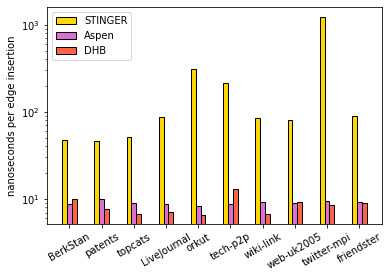

In [117]:
par_bulk_inserts(18, save=save_all_plots)

edges: [7600594, 16518947, 28511806, 68993772, 117185082, 147830697, 601038300, 936364281, 1468365181, 1806067134]
aspen_times: [61, 141, 227, 555, 909, 1174, 4797, 7373, 12114, 14353]
stinger_times: [312, 709, 1246, 4423, 33415, 20612, 33810, 60947, 166110]


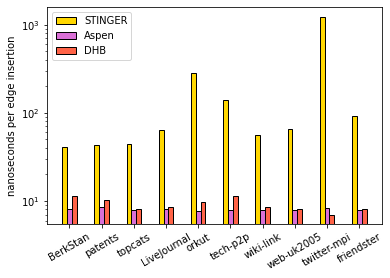

In [118]:
par_bulk_inserts(36, save=save_all_plots)

In [120]:
def memory_footprint(insertion_routine, title, save):    
    fig, ax = plt.subplots()
    sort_by = 'edges_read_in'
    
    mem_after = 'memory_footprint_kb_after_insertion'
    nk_memory_after_insert = expXThreadIR(nk_ds, 'networkit_temporal_insertions', insertion_routine, mem_after, 1, sort_by)
    print('nk: ' + str(nk_memory_after_insert))
    dhb_memory_after_insert = expXThreadIR(dhb_ds, 'dhb_temporal_insertions', insertion_routine, mem_after, 1, sort_by)
    print('dhb: ' + str(dhb_memory_after_insert))
    aspen_memory_after_insert = expXThreadIR(aspen_ds, 'aspen_temporal_insertions', insertion_routine, mem_after, 1, sort_by)
    print('aspen: ' + str(aspen_memory_after_insert))
    stinger_memory_after_insert = expXThreadIR(stinger_ds, 'stinger_temporal_insertions', insertion_routine, mem_after, 1, sort_by)
    print('stinger: ' + str(stinger_memory_after_insert))
    terrace_memory_after_insert = expXThreadIR(terrace_ds, 'terrace_temporal_insertions', insertion_routine, mem_after, 1, sort_by)
    print('terrace: ' + str(terrace_memory_after_insert))
    
    nk_memory_footprint = [kb / 1000. for kb in nk_memory_after_insert]
    dhb_memory_footprint = [kb / 1000. for kb in dhb_memory_after_insert]
    aspen_memory_footprint = [kb / 1000. for kb in aspen_memory_after_insert]
    stinger_memory_footprint = [kb / 1000. for kb in stinger_memory_after_insert]
    terrace_memory_footprint = [kb / 1000. for kb in terrace_memory_after_insert]
    
    graphs = expXThreadIR(dhb_ds, 'dhb_temporal_insertions', insertion_routine, 'graph', 1, sort_by)
    
    ax.set(ylabel='Memory Footprint in Mega Bytes (KB)')

    x = np.arange(len(graphs))  # the label locations
    width = 0.15  # the width of the bars

    ax.bar(x - 2 * width, nk_memory_footprint, width, label=gds_name_remap(nk_ds), 
           color=nk_color, hatch=nk_hatch, edgecolor='black', align='center')
    ax.bar(x - width, stinger_memory_footprint, width, label=gds_name_remap(stinger_ds), 
           color=stinger_color, hatch=stinger_hatch, edgecolor='black', align='center')
    ax.bar(x, aspen_memory_footprint, width, label=gds_name_remap(aspen_ds), 
           color=aspen_color, hatch=aspen_hatch, edgecolor='black', align='center')
    ax.bar(x + width, terrace_memory_footprint, width, label=gds_name_remap(terrace_ds), 
           color=terrace_color, hatch=terrace_hatch, edgecolor='black', align='center')
    ax.bar(x + 2*width, dhb_memory_footprint, width, label=gds_name_remap(dhb_ds), 
           color=dhb_color, hatch=dhb_hatch, edgecolor='black')
    
    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs(graphs), rotation=30)
    
#     ax.set_yscale('log', base=10)

    ax.legend()
    
    if save:
        plt.savefig('plots/memory_footprint_' + insertion_routine + '_'  + str(datetime.date.today()) + '.pdf', 
                    bbox_inches = "tight")
        # FACTORS
        append_to_factor_file('memoryFootprintVs' + nk_ds,
                              factor_compared_to(dhb_memory_after_insert, nk_memory_after_insert))
        append_to_factor_file('memoryFootprintVs' + stinger_ds,
                              factor_compared_to(dhb_memory_after_insert, stinger_memory_after_insert))
        append_to_factor_file('memoryFootprintVs' + aspen_ds,
                              factor_compared_to(dhb_memory_after_insert, aspen_memory_after_insert))
        append_to_factor_file('memoryFootprintVs' + terrace_ds,
                              factor_compared_to(dhb_memory_after_insert, terrace_memory_after_insert))
    else:
        plt.show()

nk: [88236, 176588, 542788, 1238696, 1087396, 2824208, 3074852]
dhb: [91124, 129300, 505728, 1035880, 1243652, 2880984, 3193640]
aspen: [239148, 258968, 511416, 911628, 956124, 2090168, 3599352]
stinger: [130180, 390628, 536676, 1419052, 1043780, 3265072, 3230516]
terrace: [64700, 181736, 512660, 1316484, 957928, 2090688, 3601792]


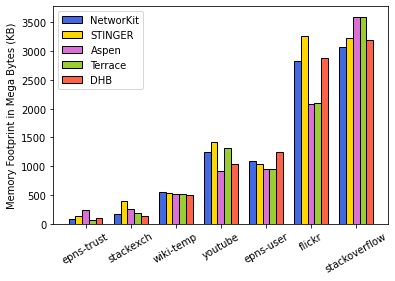

In [121]:
memory_footprint('temporal_insertions', 'Memory Footprint After Construction', save=save_all_plots)

In [122]:
def plot_rand_insert(thread_count, save=False):    
    fig, ax = plt.subplots()
    
    sort_by = 'edges_read_in'
    algo = 'rand_insert'
    experiment = 'dhb_random_insertions'
    
    times = expXThreadIR(dhb_ds, experiment, algo, 'duration_ms', thread_count, sort_by)
    vertex_count = expXThreadIR(dhb_ds, experiment, algo, 'vertex_count', thread_count, sort_by)
    edges = expXThreadIR(dhb_ds, experiment, algo, 'edge_count_after', thread_count, sort_by)
     
    times_per_edge = [(t / edge_count) * 1000000 for t, edge_count in zip(times, edges)]
    
    # title = r'Thread Count: ' + str(thread_count) + ', Inserting Random Edges, $|E| = |V| \cdot 15$'
    ax.set(xlabel=r'count of vertices |V|', ylabel='nanoseconds per edge insertion')

    ax.set_xscale('log', base=2)
    # ax.set_yscale('log', base=10)
    
    ax.plot(vertex_count, times_per_edge, 
            label=dhb_ds + ' T' + str(thread_count), marker='s', markerfacecolor=dhb_color, 
            color='black')
    
    ax.grid()
    ax.legend()

    if save:
        plt.savefig('plots/rand_insert_t' + str(thread_count) + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches = "tight")
    else:
        plt.show()

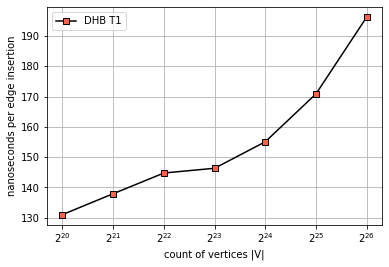

In [123]:
plot_rand_insert(1, save=save_all_plots)

In [124]:
def speedup(save=False):
    
    insertion_routine = 'insert_bulk'
    title = insertion_routine
    sort_by = 'edges_read_in'
    experiment = 'dhb_par_bulk'
    
    edges = extractExpThreadTupleIR(dhb_ds, experiment, insertion_routine, 'edges_read_in', sort_by)
    dhb_times = extractExpThreadTupleIR(dhb_ds, experiment, insertion_routine, 'duration_ms', sort_by)
    
    dhb_times_per_edge = [(count, (time / edge_count) * 1000000) for ((count, time), (count, edge_count)) in zip(dhb_times, edges)]
   
    dhb_times_per_edge_per_thread = dict()
    
    for count, time in dhb_times_per_edge:
        if count not in dhb_times_per_edge_per_thread:
            dhb_times_per_edge_per_thread[count] = [time]
        else:
            dhb_times_per_edge_per_thread[count].append(time)
    
    gm_per_edge_per_thread = []
    
    for c, times in dhb_times_per_edge_per_thread.items():
        gm_per_edge_per_thread.append((c, gmean(times)))
        
    print(gm_per_edge_per_thread)
        
    base = [time for c, time in gm_per_edge_per_thread if c == 1]
    print(base)
    speedup = []
    for c, gm in gm_per_edge_per_thread:
        speedup.append((c, base / gm))
        
    fig, ax = plt.subplots()
    ax.set_ylabel('Speedup')
    ax.set_xlabel('Thread Count')
    
    ax.plot(*zip(*speedup), label='geometric mean', marker='s', markerfacecolor=dhb_color, color='black')
    ax.set_xscale('log', base=2)
    ax.legend()

    if save:
        plt.savefig('plots/dhb_speedup_' + insertion_routine + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
    else:
        plt.show()

[(1, 36.0541887831328), (2, 34.90753993766739), (4, 18.894533098167145), (8, 11.396241654953082), (16, 8.32234915548506), (18, 8.244560448151079), (36, 9.003693758079208)]
[36.0541887831328]


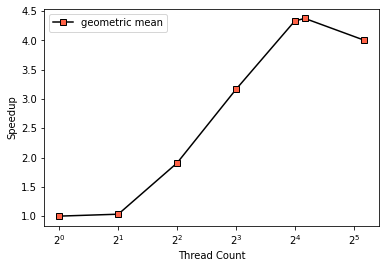

In [125]:
speedup(save=save_all_plots)

In [126]:
def compute_geometric_mean_per_batch(all_batch_sizes, times_per_edge_all):
    times_per_edge_mean = dict()
    for b, time in zip(all_batch_sizes, times_per_edge_all):
        if b not in times_per_edge_mean:
            times_per_edge_mean[b] = 1, time
        else:
            m, value = times_per_edge_mean[b]
            times_per_edge_mean[b] = m + 1, value * time
    
    geometric_mean_per_batch = []
    for b, (m, time) in times_per_edge_mean.items():
        geometric_mean_per_batch.append((b, time**(1/float(m))))   

    geometric_mean_per_batch.sort()
    return geometric_mean_per_batch

In [127]:
# fixing stinger runs not printing batch_size:
# for bs in 64 128 256 512 1024 2048 4096 8192 16384 32768 65536 131072; 
# do echo "batch_size: $bs" | tee -a output/stinger_par_batches~bs$bs\,t36@_dev/*.out; done

In [131]:
def batch_size(thread_count, save=False):
    fig, ax = plt.subplots()
    
    sort_by = 'edges_read_in'
    insertion_routine = 'insert_batch'
    dhb_exp = 'dhb_par_batches'
    aspen_exp = 'aspen_par_batches'
    stinger_exp = 'stinger_par_batches'
    terrace_exp = 'terrace_par_batches'
    
    dhb_times = expXThreadIR(dhb_ds, dhb_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_times = expXThreadIR(aspen_ds, aspen_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_times = expXThreadIR(stinger_ds, stinger_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_times = expXThreadIR(terrace_ds, terrace_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    
    dhb_all_durations = expXThreadIR(dhb_ds, dhb_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    dhb_all_edges = expXThreadIR(dhb_ds, dhb_exp, insertion_routine, 'edges_read_in', thread_count, sort_by)
    dhb_all_batch_sizes = expXThreadIR(dhb_ds, dhb_exp, insertion_routine, 'batch_size', thread_count, sort_by)

    aspen_all_durations = expXThreadIR(aspen_ds, aspen_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    aspen_all_edges = expXThreadIR(aspen_ds, aspen_exp, insertion_routine, 'edges_read_in', thread_count, sort_by)
    aspen_all_batch_sizes = expXThreadIR(aspen_ds, aspen_exp, insertion_routine, 'batch_size', thread_count, sort_by)
    
    stinger_all_durations = expXThreadIR(stinger_ds, stinger_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    stinger_all_edges = expXThreadIR(stinger_ds, stinger_exp, insertion_routine, 'edges_read_in', thread_count, sort_by)
    stinger_all_batch_sizes = expXThreadIR(stinger_ds, stinger_exp, insertion_routine, 'batch_size', thread_count, sort_by)

    terrace_all_durations = expXThreadIR(terrace_ds, terrace_exp, insertion_routine, 'duration_ms', thread_count, sort_by)
    terrace_all_edges = expXThreadIR(terrace_ds, terrace_exp, insertion_routine, 'edges_read_in', thread_count, sort_by)
    terrace_all_batch_sizes = expXThreadIR(terrace_ds, terrace_exp, insertion_routine, 'batch_size', thread_count, sort_by)
    
    dhb_times_per_edge_all = [(t / edge_count) * 1000000 for t, edge_count in zip(dhb_all_durations, dhb_all_edges)]
    aspen_times_per_edge_all = [(t / edge_count) * 1000000 for t, edge_count in zip(aspen_all_durations, aspen_all_edges)]
    stinger_times_per_edge_all = [(t / edge_count) * 1000000 for t, edge_count in zip(stinger_all_durations, stinger_all_edges)]
    terrace_times_per_edge_all = [(t / edge_count) * 1000000 for t, edge_count in zip(terrace_all_durations, terrace_all_edges)]
    
    ax.scatter(dhb_all_batch_sizes, dhb_times_per_edge_all, color=dhb_color, marker='+', label=dhb_ds)
    ax.scatter(aspen_all_batch_sizes, aspen_times_per_edge_all, color=aspen_color, marker='+', label=gds_name_remap(aspen_ds))
    ax.scatter(stinger_all_batch_sizes, stinger_times_per_edge_all, color=stinger_color, marker='+', label=gds_name_remap(stinger_ds))
#     ax.scatter(terrace_all_batch_sizes, terrace_times_per_edge_all, color=terrace_color, marker='+', label=gds_name_remap(terrace_ds))
    
    dhb_geometric_mean_per_batch = compute_geometric_mean_per_batch(dhb_all_batch_sizes, dhb_times_per_edge_all)
    aspen_geometric_mean_per_batch = compute_geometric_mean_per_batch(aspen_all_batch_sizes, aspen_times_per_edge_all)
    stinger_geometric_mean_per_batch = compute_geometric_mean_per_batch(stinger_all_batch_sizes, stinger_times_per_edge_all)
    terrace_geometric_mean_per_batch = compute_geometric_mean_per_batch(terrace_all_batch_sizes, terrace_times_per_edge_all)
        
    ax.plot(*zip(*dhb_geometric_mean_per_batch), label=dhb_ds + ' G.M.', marker='s', 
            markerfacecolor=dhb_color, color='black')
    ax.plot(*zip(*aspen_geometric_mean_per_batch), label=gds_name_remap(aspen_ds) + ' G.M.', marker='s', 
            markerfacecolor=aspen_color, color='black')
    ax.plot(*zip(*stinger_geometric_mean_per_batch), label=gds_name_remap(stinger_ds) + ' G.M.', marker='s', 
           markerfacecolor=stinger_color, color='black')
#     ax.plot(*zip(*terrace_geometric_mean_per_batch), label=gds_name_remap(terrace_ds) + ' G.M.', marker='s', 
#            markerfacecolor=terrace_color, color='black')
    
    ax.set(xlabel=r'Batch Size', ylabel='nanoseconds per edge insertion')
    # ax.set(title=r'thread count: ' + str(thread_count))
    ax.legend()
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.grid()

    if save:
        plt.savefig('plots/batch_size_thread_count_' + str(thread_count) 
                    + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches = "tight")
    else:
        plt.show()

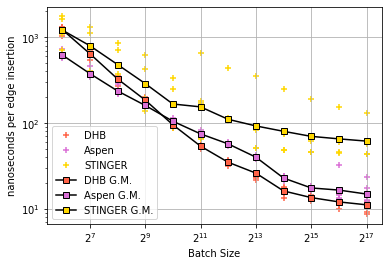

In [132]:
batch_size(36, save=save_all_plots)

In [134]:
def native_vs_dhb_vs_csr_nk_bfs(save=False):    
    fig, ax = plt.subplots()

    sort_by = 'edges_read_in' 
    algo = 'bfs'
    vanilla_times = extractExperimentSingleThread(nk_ds, 'nkv_bfs', algo, 'duration_ms', sort_by)
    print(vanilla_times)
    
    dhb_times = extractExperimentSingleThread(nk_ds, 'nkdhb_bfs', algo, 'duration_ms', sort_by)
    csr_times = extractExperimentSingleThread(nk_ds, 'csr_bfs', 'csr_bfs', 'duration_ms', sort_by)
    
    graphs = extractExperimentSingleThread(nk_ds, 'nkdhb_bfs', algo, 'graph', sort_by)
    print(graphs)

    ax.set_ylabel('time (ms)')
    # ax.set_title('NetworKit + Vanilla vs. CSR vs. DHB: BFS')

    x = np.arange(len(graphs))  # the label locations
    width = 0.2  # the width of the bars
    
    ax.bar(x - width, vanilla_times, width, label='Native', color=nk_color, hatch=nk_hatch, edgecolor='black')
    ax.bar(x, csr_times, width, label='CSR', color=csr_color, hatch=csr_hatch,
           edgecolor='black')
    ax.bar(x + width, dhb_times, width, label='DHB', color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs(graphs), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
        plt.savefig('plots/vanilla_vs_dhb_vs_csr_nk_bfs_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file('bfsVsVanillla',
                          factor_compared_to(dhb_times, vanilla_times))
        append_to_factor_file('bfsVsCsr',
                          factor_compared_to(dhb_times, csr_times))
    else:
        plt.show()

[8283, 41349, 46348, 130771, 165063, 210019, 965345, 874970]
['web-BerkStan', 'cit-Patents', 'wiki-topcats', 'soc-LiveJournal1', 'com-orkut', 'tech-p2p', 'web-wikipedia_link_en13', 'web-uk-2005']


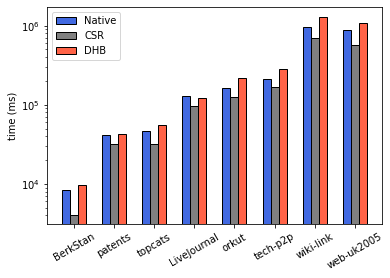

In [135]:
native_vs_dhb_vs_csr_nk_bfs(save_all_plots)

In [136]:
def native_vs_dhb_vs_csr_nk_spmv(save=False):    
    fig, ax = plt.subplots()

    sort_by = 'edges_read_in' 
    algo = 'spmv'
    vanilla_times = extractExperimentSingleThread(nk_ds, 'nkv_spmv', algo, 'duration_ms', sort_by)
    print(vanilla_times)
    
    dhb_times = extractExperimentSingleThread(nk_ds, 'nkdhb_spmv', algo, 'duration_ms', sort_by)
    dhb_times.append(1800000.)
    
    csr_times = extractExperimentSingleThread(nk_ds, 'csr_spmv', 'csr_spmv', 'duration_ms', sort_by)
    csr_times.append(1800000.)
    
    graphs = extractExperimentSingleThread(nk_ds, 'nkv_spmv', algo, 'graph', sort_by)
    print(graphs)

    ax.set_ylabel('time (ms)')
    # ax.set_title('NetworKit + Vanilla vs. CSR vs. DHB: BFS')

    x = np.arange(len(graphs))  # the label locations
    width = 0.2  # the width of the bars
    
    ax.bar(x - width, vanilla_times, width, label='Native', color=nk_color, hatch=nk_hatch, edgecolor='black')
    ax.bar(x, csr_times, width, label='CSR', color=csr_color, hatch=csr_hatch, edgecolor='black')
    ax.bar(x + width, dhb_times, width, label='DHB', color=dhb_color, hatch=dhb_hatch, edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels(get_abbr_for_graphs(graphs), rotation=30)
    ax.set_yscale('log', base=10)
    
    ax.legend()

    if save:
        plt.savefig('plots/vanilla_vs_dhb_vs_csr_nk_spmv_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
        append_to_factor_file('spmvVsVanillla',
                          factor_compared_to(dhb_times, vanilla_times))
        append_to_factor_file('spmvVsCsr',
                          factor_compared_to(dhb_times, csr_times))
    else:
        plt.show()

[726, 5606, 4027, 11605, 18128, 29218, 122724, 75550, 291799, 550888]
['web-BerkStan', 'cit-Patents', 'wiki-topcats', 'soc-LiveJournal1', 'com-orkut', 'tech-p2p', 'web-wikipedia_link_en13', 'web-uk-2005', 'soc-twitter-mpi-sws', 'com-friendster']


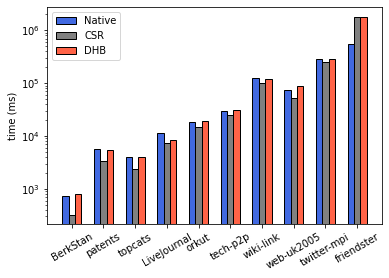

In [137]:
native_vs_dhb_vs_csr_nk_spmv(True)

In [138]:
# experimental not part of paper

In [139]:
def times_per_edge(times, edges):
    return [(count, (time / edge_count) * 1000000) for ((count, time), (count, edge_count)) in zip(times, edges)]

In [140]:
def times_per_edge_per_thread(times_per_edge):
    times_per_edge_per_thread = dict()
    
    for count, time in times_per_edge:
        if count not in times_per_edge_per_thread:
            times_per_edge_per_thread[count] = [time]
        else:
            times_per_edge_per_thread[count].append(time)
            
    return times_per_edge_per_thread

In [141]:
def gm_per_edge_per_thread(times_per_edge_per_thread):
    gm_per_edge_per_thread = []
    
    for c, times in times_per_edge_per_thread.items():
        gm_per_edge_per_thread.append((c, gmean(times)))

    return gm_per_edge_per_thread

In [142]:
def get_speedup(gm_per_edge_per_thread, base):
    speedup = []
    for c, gm in gm_per_edge_per_thread:
        speedup.append((c, base / gm))
    return speedup

In [144]:
def speedup_compare_all(save=False):
    
    insertion_routine = 'insert_bulk'
    title = 'dhb_v_aspen_v_stinger'
    sort_by = 'edges_read_in'
    
    edges = extractExpThreadTupleIR(dhb_ds, 'dhb_par_bulk', insertion_routine, 'edges_read_in', sort_by)
    
    dhb_times = extractExpThreadTupleIR(dhb_ds, 'dhb_par_bulk', insertion_routine, 'duration_ms', sort_by)
    stinger_times = extractExpThreadTupleIR(stinger_ds, 'stinger_par_bulk', insertion_routine, 'duration_ms', sort_by)
    aspen_times = extractExpThreadTupleIR(aspen_ds, 'aspen_par_bulk', insertion_routine, 'duration_ms', sort_by)
    terrace_times = extractExpThreadTupleIR(terrace_ds, 'terrace_par_bulk', insertion_routine, 'duration_ms', sort_by)
    
    dhb_times_per_edge = times_per_edge(dhb_times, edges)
    stinger_times_per_edge = times_per_edge(stinger_times, edges)
    aspen_times_per_edge = times_per_edge(aspen_times, edges)
    terrace_times_per_edge = times_per_edge(terrace_times, edges)
   
    dhb_times_per_edge_per_thread = times_per_edge_per_thread(dhb_times_per_edge)
    stinger_times_per_edge_per_thread = times_per_edge_per_thread(stinger_times_per_edge)
    aspen_times_per_edge_per_thread = times_per_edge_per_thread(aspen_times_per_edge)
    terrace_times_per_edge_per_thread = times_per_edge_per_thread(terrace_times_per_edge)
    
    dhb_gm_per_edge_per_thread = gm_per_edge_per_thread(dhb_times_per_edge_per_thread)
    stinger_gm_per_edge_per_thread = gm_per_edge_per_thread(stinger_times_per_edge_per_thread)
    aspen_gm_per_edge_per_thread = gm_per_edge_per_thread(aspen_times_per_edge_per_thread)
    terrace_gm_per_edge_per_thread = gm_per_edge_per_thread(terrace_times_per_edge_per_thread)
        
    base = [time for c, time in dhb_gm_per_edge_per_thread if c == 1]
    
    dhb_speedup = get_speedup(dhb_gm_per_edge_per_thread, base)
    stinger_speedup = get_speedup(stinger_gm_per_edge_per_thread, base)
    aspen_speedup = get_speedup(aspen_gm_per_edge_per_thread, base)
    terrace_speedup = get_speedup(terrace_gm_per_edge_per_thread, base)
        
    fig, ax = plt.subplots()
    ax.set_ylabel('Speedup')
    ax.set_xlabel('Thread Count')
    
    ax.plot(*zip(*dhb_speedup), label=dhb_ds + ' G.M.', linestyle='solid', marker='s', markerfacecolor=dhb_color, color='black')
    ax.plot(*zip(*stinger_speedup), label=gds_name_remap(stinger_ds) + ' G.M.', linestyle='dotted', marker='s', markerfacecolor=stinger_color, color='black')
    ax.plot(*zip(*aspen_speedup), label=gds_name_remap(aspen_ds) + ' G.M.', linestyle='dashed', marker='s', markerfacecolor=aspen_color, color='black')
#     ax.plot(*zip(*terrace_speedup), label=terrace_ds + ' G.M.', linestyle='dashed', marker='s', markerfacecolor=terrace_color, color='black')
    
    ax.set_xscale('log', base=2)
    ax.legend()

    if save:
        plt.savefig('plots/' + title + '_speedup_' + insertion_routine + '_' + str(datetime.date.today()) + '.pdf', 
                    bbox_inches='tight')
    else:
        plt.show()

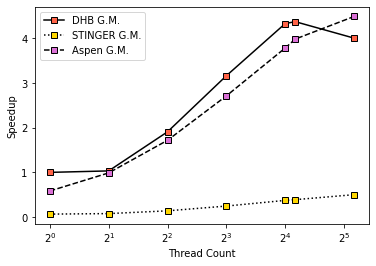

In [145]:
speedup_compare_all(save=save_all_plots)